In [1]:
import numpy as np
import trident
import yt
import os
import sys
import matplotlib.pyplot as plt
from quasar_scan import *
from parse_vela_metadata import Rdict, Ldict

In [31]:
#precondition: assumes there are only two levels of depth within the output folder
#postcondition: returns a list of all textfiles
def get_all_textfiles():
    
    #pathname by default starts in output
    path = "output"
    
    textfiles = []
    
    #gets all folders in output
    dirs = os.listdir(path)
    for folderName in dirs:
        if not folderName.startswith("."):
            folderPath = path + "/" + folderName
            folderDirs = os.listdir(folderPath)
            for fileName in folderDirs:
                textfiles.append(os.path.join(folderPath,fileName))
    return textfiles
    print "All textfiles loaded!"
        
    



class MultiQuasarSpherePlotter():
    #USER MUST EXPLICITLY CALL GET_QUASAR TO INPUT INTO ALL OTHER MULTIQUASARSPHEREPLOTTER METHODS AS NECESSARY
    
    
    #param: textfiles     if a list of textfiles is specified, those specific textfiles will be loaded; else,
    #                     all textfiles in output are loaded
    def __init__(self, textfiles = None):
        self.quasarLineup = []
        if not textfiles:
            textfiles = get_all_textfiles()
        for textfile in textfiles:
            try:
                simparams,scanparams,ions,data = read_values(textfile)
                q = QuasarSphere(simparams = simparams,scanparams = scanparams,ions = ions,data = data, readonly = True)
                if q.scanparams[5] > 100:
                    self.quasarLineup.append(q)
            except:
                print(":(")
                print(textfile + " could not load.")
        print self.quasarLineup
    
    #summary: uses param simname and param redshift (and param ions) to search through instance variable quasarLineup and 
    #         return the matching quasar if found
    def get_quasar(self, simname, redshift, ions = None):
        result = None
        for quasar in self.quasarLineup:
            tempSimName = quasar.simparams[0]
            tempRedshift = round(quasar.simparams[1], 2)
            if ions:
                tempIons = quasar.ions
                if tempSimName == simname and tempRedshift == redshift and tempIons == ions:
                    return quasar
            else:
                if tempSimName == simname and tempRedshift == redshift:
                    return quasar
        print ("Quasar with inputted characteristics not found.")
        
    def sort_by(self, criteria):
        return 
    

    #summary: plots an a pyplot errorbar graph with the x-axis being either theta, phi, or the radius; 
    #         the y-axis points are the mean column densities with a spread of +/- the error
    #         quasarArray is the array of quasars to be plotted
    def plot_coldens_error_bars(self, ion, quasarArray = None, xVar = "r", more_info = False, save_fig = False):

        plt.figure()
        #axs.errorbar(x[1:], y[1:], yerr=yerr[1:], fmt='_')

        xlabels = {"r":"r (kpc)","r>0":"r (kpc)","rdivR":"r/Rvir","theta":"viewing angle (rad)","phi" \
                   :"azimuthal viewing angle (rad)"}
        
        plt.xlabel(xlabels[xVar])
        plt.ylabel("log col dens")
        plt.title('%s Column Density Averages vs %s' % (ion, xVar) )
        
        
        if not quasarArray:
            quasarArray = self.quasarLineup
            print quasarArray

        for index in range(len(quasarArray)):
                
            q = quasarArray[index]
            #list of all possibles xVals, with no repeats
            allX = self.find_xVars_info(q, xVar)
            x = np.unique(allX)


            #list of column density AVERAGES corresponding to the respective xVal
            
            y = np.zeros(len(x))
            yerr = np.zeros(len(x))


            ionIndex = -1
            for index in range(len(q.ions)):
                if q.ions[index] == ion:
                    ionIndex = index
            if ionIndex == -1:
                print ("Ion not found. Please enter a different ion.")
                return
            if more_info:
                print ("Ion index found at %d \n" %ionIndex)


            allColdens = q.info[:,11 + ionIndex] 


            #loops to find column density (y) mean and +/- error
            
            for index in range(len(x)):
                yTemp = allColdens[allX == x[index]]

                logYTemp = np.log10(yTemp)
                if more_info:
                    print ("At x value %f, log y is %s" % (x[index], logYTemp))

                #finds mean at given xVar  
                avg = np.mean(logYTemp)
                y[index] = avg

                print ("Column density mean at %5f %s is %5f" % (x[index], xVar, avg))

                stdev = np.std(logYTemp)
                error = stdev / np.sqrt(len(logYTemp))
                yerr[index] = error
                if more_info:
                    print("+/- error value is %5f \n" %error) 
            if xVar == "r>0" and x[0] == 0.0:
                x = x[1:]
                y = y[1:]
                yerr = yerr[1:]
            plt.errorbar(x, y, yerr=yerr, fmt='_', label = q.simparams[0])
            plt.legend()


        if save_fig == True:
            ionNameNoSpaces = ion.replace(" ","")
            name = "%s_z%0.2f_ErrorBar_%s_%s" % (q.simparams[0], q.simparams[1], ionNameNoSpaces, xVar)
            plt.savefig(name + ".png")
    
    #summary: calculates the right index corresponding to xvariable, then finds (in 'info') and returns that array
    #precondition: xVar must be "theta","phi","r","r>0","rdivR"
    def find_xVars_info(self, q, xvariable):
        if xvariable == "r" or xvariable == "r>0":
            conversion = q.simparams[10]
        elif xvariable == "rdivR":
            if q.simparams[5] > 0:
                conversion = q.simparams[10]/q.simparams[5]
            else:
                print("No virial radius found")
                return
        else:
            if q.simparams[5] < 0:
                print("No metadata, angle plots will be arbitrary axis.")
            conversion = 1

        vardict = {"theta":1,"phi":2,"r":3,"r>0":3,"rdivR":3}
        if not (xvariable in vardict):
            print ("Inputted xvariable not found. Please enter a valid xvariable.")
            return

        return q.info[:, vardict[xvariable]]*conversion
    
    #summary: plots histogram(s) of ion column density vs incrementing xvariable, 
    #         uses a color bar to show the percentage of sightlines for a certain column density at a specific x value
    def plot_hist(self, q, simname = None,xvariable = "r",zeros = "ignore",\
                  weights = True,save_fig = None,ns = (42,15),do_ions = "all"):
        if not simname:
            simname = q.simparams[0]
        if do_ions == "all":
            ions = q.ions
        else:
            ions = do_ions
        xVarsArray = self.find_xVars_info(q, xvariable)
        #ion,xvars,cdens,simname
        for i in range(len(q.ions)):
            end = q.scanparams[6]
            if q.ions[i] in ions:
                plot2dhist(q.ions[i],xVarsArray,\
                       q.info[:end,11+i],simname,xvariable = xvariable, ns = ns,zeros = zeros,\
                       weights = weights,save_fig = save_fig,z = q.simparams[1])

#summary: helper method for plot_hist                
def plot2dhist(ion,xvars,cdens,simname,xvariable = "r",ns = (42,15),zeros = "ignore",weights = True, save_fig = None, z = None):
    if zeros == "ignore":
        xvars = xvars[cdens>0]
        cdens = cdens[cdens>0]
        logdens = np.log10(cdens)
    else:
        logdens = np.log10(np.maximum(cdens,1e-15))
    if xvariable == "r>0":
        logdens = logdens[xvars>0.0]
        xvars = xvars[xvars>0.0]
    nx = ns[0]
    ny = ns[1]
    plotvars = {"r":"r","r>0":"r","rdivR":"r","theta":"theta","phi":"phi"}
    plotvar = plotvars[xvariable]
    if weights:
        weight = xvars*0.0
        for i in range(len(xvars)):
            weight[i] = 1.0/len(xvars[xvars==xvars[i]])
        H, xedges, yedges = np.histogram2d(xvars, logdens, bins=[nx,ny],weights = weight)
        cbarlabel = "Fraction of lines for fixed %s"%(plotvar)
    else:
        H, xedges, yedges = np.histogram2d(xvars, logdens, bins=[nx,ny])
        cbarlabel = "Total number of lines"
    H = H.T
    X, Y = np.meshgrid(xedges, yedges)
    plt.pcolormesh(X,Y, H, cmap=hotcustom)
    plt.title("distribution of "+ion+" in "+simname+" at z="+str(z)[:4])
    # set the limits of the plot to the limits of the data
    #plt.axis([x.min(), x.max(), y.min(), y.max()])
    plt.colorbar(label = cbarlabel)
    x1,x2,y1,y2 = plt.axis()
    dx = x2-x1
    dy = y2-y1
    plt.axis((x1-dx*0.1,x2+dx*0.1,y1-dy*0.1,y2+dy*0.1))
    xlabels = {"r":"r (kpc)","r>0":"r (kpc)","rdivR":"r/Rvir","theta":"viewing angle (rad)","phi":"azimuthal viewing angle (rad)"}
    plt.xlabel(xlabels[xvariable])
    plt.ylabel("log col dens")
    if save_fig:
        if save_fig == "default" :
            save_fig = simname + "_" + plotvar + "_z" +str(z)[:4]
        name = save_fig+"_"+ion.replace(" ","")
        if weights:
            name +="_w"
        if zeros == "ignore":
            name +="_nozeros"
        plt.savefig(name+".png")
    plt.show()


    
        
    #def graph_by_VELA_galaxy():
        
    #def graph_by_redshift():
        
        


In [ ]:
textfile = '/Users/bryanwang/quasarscan/output/VELA_v2_03coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt'
simparams, scanparams, ions, data = read_values(textfile)
q = QuasarSphere(simparams = simparams, scanparams = scanparams, ions = ions, data = data, readonly = True)
#q.__dict__.keys()

[<quasar_scan.QuasarSphere object at 0x116e47f10>, <quasar_scan.QuasarSphere object at 0x1168f81d0>, <quasar_scan.QuasarSphere object at 0x116d923d0>, <quasar_scan.QuasarSphere object at 0x116d92910>, <quasar_scan.QuasarSphere object at 0x116fd2c10>, <quasar_scan.QuasarSphere object at 0x116fd2ed0>, <quasar_scan.QuasarSphere object at 0x116fd2d10>, <quasar_scan.QuasarSphere object at 0x116fd2cd0>, <quasar_scan.QuasarSphere object at 0x116fd25d0>, <quasar_scan.QuasarSphere object at 0x116fd2e50>, <quasar_scan.QuasarSphere object at 0x116fd2610>, <quasar_scan.QuasarSphere object at 0x116fd29d0>, <quasar_scan.QuasarSphere object at 0x1162a3550>, <quasar_scan.QuasarSphere object at 0x1162a3a10>, <quasar_scan.QuasarSphere object at 0x1162a35d0>, <quasar_scan.QuasarSphere object at 0x1162a3f90>, <quasar_scan.QuasarSphere object at 0x1162a3d50>, <quasar_scan.QuasarSphere object at 0x1162a3910>, <quasar_scan.QuasarSphere object at 0x1162a3710>, <quasar_scan.QuasarSphere object at 0x1162a3610>,

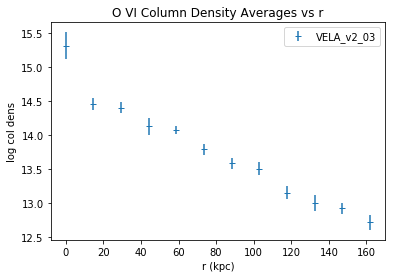

In [35]:
textfiles = ['/Users/bryanwang/quasarscan/output/VELA_v2_03coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt', '/Users/bryanwang/quasarscan/output/VELA_v2_01coldensinfo/406_of_400-_OVI_NeVIII_HI_CIII_OIV_NIII_MgII_OV_OIII_NIV_MgX_NV_SIV_OII_SIII_SII_SV_SVI_NII_z0.99.txt']
mq = MultiQuasarSpherePlotter()
q1 = mq.get_quasar("VELA_v2_03", 1.00)
q2 = mq.get_quasar("VELA_v2_01", 1.00)

#mq.plot_hist(q1)
mq.plot_coldens_error_bars("O VI", xVar = "r", quasarArray = [q1])


#mq.plot_hist(0,do_ions = ["O VI","Ne VIII"])
#mq.plot_coldens_error_bars([q1, q2],"O VI", xVar = "phi", more_info = False)
